In [1]:
import os

import dask
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import gc

C:\Users\Sandhya\Anaconda3\envs\PythonData\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Sandhya\Anaconda3\envs\PythonData\lib\site-packages\numpy\.libs\libopenblas.BNVRK7633HSX7YVO2TADGR4A5KEKXJAW.gfortran-win_amd64.dll
C:\Users\Sandhya\Anaconda3\envs\PythonData\lib\site-packages\numpy\.libs\libopenblas.CSRRD7HKRKC3T3YXA7VY7TAZGLSWDKW6.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
weather_df_cols = ['station','date','element','value','mflag','qflag','sflag','obstime']
use_cols = ['station','date','element','value']

NOAA has made daily weather details available for all over the world. This is available as a csv.gz for each year at
ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/

Each yearly file has ~65M rows, and takes more than 4 GB of memory to load. If one wants to analyze the weather data through time, it will not fit in memory.

I wanted to analyze the weather changes from 2008 to 2019. One of my attempts was to use Dask, however, it still did not fit in memory and it did not provide features I wanted to use.

First step in dealing with data is to define what needs to be accomplished. In this case, I'd like to plot/examine max temperature, min temperature and precipitation changes in the Austin, TX area. So, instead of using dask, I subset the yearly data according to this criteria, and then plot it.

Reading each data csv after download takes about 3.5 mins on my machine. Filtering it to create a subset of data I need takes another half a min. Since there are 11 files, the total operation takes about 4 * 11 mins, ~40 mins in total. Since most of the time is spent in IO, not much improvement ccan be made.

Garbage collection does not give any improvement here.

First, get a list of station names which meet my criteria: Austin TX USA location (latitude 30.2672° N, longitude 97.7431° W), has data from 2008 to 2019, and the three kinds of data that I need: TMAX, TMIN and PRCP. Note that multiple stations are available in the area.

In [3]:
inventory_df = pd.read_fwf("data/ghcnd-inventory.txt",header=None, names=['station','latitude','longitude',
                                'element','first_year','last_year'])

In [4]:
condition = (inventory_df['station'].apply(lambda x : x[0:2]) == 'US') & \
            (inventory_df['first_year']<2008) & \
            (inventory_df['last_year'] >=2019) & \
            (inventory_df['element'].isin(['TMAX','TMIN','PRCP'])) &\
            (inventory_df['latitude'].between(30,31)) & (inventory_df['longitude'].between(-98,-97))

inventory_df[condition].sort_values(['latitude','longitude'])

,station,latitude,longitude,element,first_year,last_year
324294,US1TXFY0003,30.0080,-97.0052,PRCP,2007,2019
576349,USC00418415,30.0092,-97.1644,TMAX,1921,2019
576350,USC00418415,30.0092,-97.1644,TMIN,1921,2019
576352,USC00418415,30.0092,-97.1644,PRCP,1917,2019
320640,US1TXBST017,30.0287,-97.5496,PRCP,2007,2019
320620,US1TXBST007,30.1306,-97.3025,PRCP,1998,2019
320794,US1TXBST078,30.1661,-97.2553,PRCP,1998,2019
630632,USR0000TBAS,30.1742,-97.2564,TMAX,2003,2019
630633,USR0000TBAS,30.1742,-97.2564,TMIN,2003,2019
647685,USW00013904,30.1831,-97.6800,TMAX,1948,2019


In [5]:
us_stations = inventory_df[condition]['station'].values


The following cells demonstrate the processing needed on one file, so that a loop can later be used on all years. Notice that the reading the csv takes a lot of time

In [6]:
%%time
all_2008_df = pd.read_csv('data/2008.csv.gz', header=None,names=weather_df_cols, index_col=None, parse_dates=['date'])
print(all_2008_df.memory_usage().sum()*1e-6)

4200.35112
Wall time: 3min 32s


Getting a subset of the information we need from the 65M rows does not take much time.

In [7]:
%%time
us_2008_df = all_2008_df[all_2008_df['station'].isin(us_stations) & all_2008_df['element'].isin(['TMAX','TMIN','PRCP'])][use_cols].reset_index(drop=True)
us_2008_df.memory_usage().sum()*1e-6

Wall time: 8.98 s


In [8]:
us_2008_df.head()

,station,date,element,value
0,US1TXTV0027,2008-01-01,PRCP,0
1,US1TXTV0010,2008-01-01,PRCP,0
2,USC00412820,2008-01-01,TMAX,217
3,USC00412820,2008-01-01,TMIN,0
4,USC00412820,2008-01-01,PRCP,0


Pandas has a convinient function for custom groupings called `Grouper`. It can be used to group monthly.

In [9]:
%%time
us_2008_monthly = us_2008_df.groupby(['station','element',pd.Grouper(key='date',freq='M')])['value'].mean()

Wall time: 214 ms


In [10]:
us_2008_monthly.head(10)

station      element  date      
US1TXBST002  PRCP     2008-01-31     7.250000
                      2008-02-29    18.785714
                      2008-03-31    25.580645
                      2008-04-30    25.466667
                      2008-05-31    29.724138
                      2008-06-30     2.357143
                      2008-07-31     8.354839
                      2008-08-31    12.870968
                      2008-09-30     6.033333
                      2008-10-31     5.677419
Name: value, dtype: float64

Another way to group monthly, and much faster too.

In [11]:
%%time
us_2008_monthly2 = us_2008_df.groupby(['station','element',us_2008_df.date.dt.month])['value'].mean()
us_2008_monthly.head(10)

Wall time: 30.8 ms


In [12]:
us_2008_monthly.memory_usage()*1e-6

0.008427

Unstacking gives a very nice table.

In [13]:
us_2008_monthly_df = us_2008_monthly.unstack(level=-1,fill_value=0)
us_2008_monthly_df.head(50)

,date,2008-01-31 00:00:00,2008-02-29 00:00:00,2008-03-31 00:00:00,2008-04-30 00:00:00,2008-05-31 00:00:00,2008-06-30 00:00:00,2008-07-31 00:00:00,2008-08-31 00:00:00,2008-09-30 00:00:00,2008-10-31 00:00:00,2008-11-30 00:00:00,2008-12-31 00:00:00
station,element,,,,,,,,,,,,
US1TXBST002,PRCP,7.250000,18.785714,25.580645,25.466667,29.724138,2.357143,8.354839,12.870968,6.033333,5.677419,1.033333,4.100000
US1TXBST007,PRCP,11.935484,12.607143,23.206897,17.500000,2.516129,0.433333,11.677419,26.000000,2.200000,8.516129,1.433333,7.419355
US1TXBST017,PRCP,9.000000,8.259259,15.500000,90.600000,8.000000,19.000000,104.000000,86.375000,112.000000,65.000000,5.000000,61.000000
US1TXFY0003,PRCP,84.000000,155.750000,152.600000,265.500000,32.000000,86.500000,83.400000,93.714286,33.000000,100.666667,41.000000,58.000000
US1TXMLM001,PRCP,11.838710,12.724138,29.225806,37.366667,41.709677,2.300000,10.645161,30.354839,3.035714,23.806452,3.600000,4.857143
US1TXTV0001,PRCP,8.516129,2.793103,25.419355,32.866667,9.290323,12.066667,8.935484,28.612903,0.166667,21.870968,3.100000,3.419355
US1TXTV0002,PRCP,7.548387,46.666667,51.916667,37.500000,15.363636,5.766667,10.516129,43.875000,0.000000,24.193548,6.827586,21.750000
US1TXTV0008,PRCP,7.750000,8.444444,75.272727,72.785714,15.285714,8.423077,32.772727,39.181818,0.312500,35.875000,7.250000,3.944444
US1TXTV0009,PRCP,7.931034,4.307692,24.100000,35.107143,4.400000,29.000000,8.580645,14.433333,0.185185,27.173913,1.600000,5.130435


In [14]:
us_2008_monthly = us_2008_monthly.reset_index()
us_2008_monthly.head()

,station,element,date,value
0,US1TXBST002,PRCP,2008-01-31,7.250000
1,US1TXBST002,PRCP,2008-02-29,18.785714
2,US1TXBST002,PRCP,2008-03-31,25.580645
3,US1TXBST002,PRCP,2008-04-30,25.466667
4,US1TXBST002,PRCP,2008-05-31,29.724138


In [15]:
all_2008_df.shape

(65630485, 8)

The problem with all this data is that it will not fit into memory. The point here is to divide-and-conquor.
1. Define what information is needed from each year's data.
2. Extract that information, make sure that it is small.
3. Do it over all years, and then build the complete dataframe to that it can be analyzed.

Deleting the dataframe above and doing garbage collection since this DF was only for demonstration of steps. Otherwise, the following steps will fail on my machine.

In [16]:
del all_2008_df
gc.collect()

82

### Method 1
This reads all the csvs directly and builds the data needed. Takes about 40mins, this is the baseline. If the same actions have to be repeated for another location, the whole process has to be repeated again and again. Note that most of the time is spent in reading the csv file as demonstrated above.

In [17]:
%%time
years_list = [str(y) for y in range(2008,2020)]
df_weekly_list = []
for year in years_list:
    print("Processing year: "+year)
    weather_df = pd.read_csv('data/'+year+".csv.gz", header=None, names=weather_df_cols, 
                             index_col=None, parse_dates=['date'])
    print("DF shape : ", weather_df.shape)
    print("DF memory usage : ", weather_df.memory_usage().sum()*1e-6)
    us_df = weather_df[weather_df['station'].isin(us_stations) & weather_df['element'].isin(['TMAX','TMIN','PRCP'])][use_cols]
    us_weekly = us_df.groupby(['station','element',pd.Grouper(key='date',freq='W')])['value'].mean().reset_index()
    df_weekly_list.append(us_weekly)


Processing year: 2008
DF shape :  (65630485, 8)
DF memory usage :  4200.35112
Processing year: 2009
DF shape :  (66964986, 8)
DF memory usage :  4285.759184
Processing year: 2010
DF shape :  (68378035, 8)
DF memory usage :  4376.19432
Processing year: 2011
DF shape :  (63661908, 8)
DF memory usage :  4074.3621919999996
Processing year: 2012
DF shape :  (64146664, 8)
DF memory usage :  4105.386576
Processing year: 2013
DF shape :  (64109737, 8)
DF memory usage :  4103.0232479999995
Processing year: 2014
DF shape :  (63499470, 8)
DF memory usage :  4063.96616
Processing year: 2015
DF shape :  (65366841, 8)
DF memory usage :  4183.477903999999
Processing year: 2016
DF shape :  (67170403, 8)
DF memory usage :  4298.905871999999
Processing year: 2017
DF shape :  (67399130, 8)
DF memory usage :  4313.5444
Processing year: 2018
DF shape :  (67207227, 8)
DF memory usage :  4301.262608
Processing year: 2019
DF shape :  (23992603, 8)
DF memory usage :  1535.526672
Wall time: 45min 1s


### Method 2
Apache parquet is a binary data storage format which achieves high compression and is suitable for fast IO access. If the csv files have to be read again and again, it will be more efficient to write it to parquet to speed it up. As seen below, this gives about half an hour of overhead initially (40 mins vs 1 hr 10 mins), but as demonstrated in the next cell, reading all the data from parquet format takes only about 15 mins vs the 40 mins for csv files.

In [18]:
%%time
years_list = [str(y) for y in range(2008,2020)]
df_monthly_list = []
df_daily_list = []
for year in years_list:
    print("Processing year: "+year)
    weather_df = pd.read_csv('data/'+year+".csv.gz", header=None, names=weather_df_cols, 
                             index_col=None, parse_dates=['date'])
    print("DF shape : ", weather_df.shape)
    print("DF memory usage : ", weather_df.memory_usage().sum()*1e-6)
    us_df = weather_df[weather_df['station'].isin(us_stations) & weather_df['element'].isin(['TMAX','TMIN','PRCP'])][use_cols]
    us_weekly = us_df.groupby(['station','element',pd.Grouper(key='date',freq='W')])['value'].mean().reset_index()
    df_weekly_list.append(us_weekly)
    weather_df.to_parquet('parquet/'+year+'.parquet')


Processing year: 2008
DF shape :  (65630485, 8)
DF memory usage :  4200.35112
Processing year: 2009
DF shape :  (66964986, 8)
DF memory usage :  4285.759184
Processing year: 2010
DF shape :  (68378035, 8)
DF memory usage :  4376.19432
Processing year: 2011
DF shape :  (63661908, 8)
DF memory usage :  4074.3621919999996
Processing year: 2012
DF shape :  (64146664, 8)
DF memory usage :  4105.386576
Processing year: 2013
DF shape :  (64109737, 8)
DF memory usage :  4103.0232479999995
Processing year: 2014
DF shape :  (63499470, 8)
DF memory usage :  4063.96616
Processing year: 2015
DF shape :  (65366841, 8)
DF memory usage :  4183.477903999999
Processing year: 2016
DF shape :  (67170403, 8)
DF memory usage :  4298.905871999999
Processing year: 2017
DF shape :  (67399130, 8)
DF memory usage :  4313.5444
Processing year: 2018
DF shape :  (67207227, 8)
DF memory usage :  4301.262608
Processing year: 2019
DF shape :  (23992603, 8)
DF memory usage :  1535.526672
Wall time: 1h 13min 42s


In [19]:
%%time
years_list = [str(y) for y in range(2008,2020)]
df_weekly_list = []
df_daily_list = []
for year in years_list:
    print("Processing year: "+year)
    weather_df = pd.read_parquet('parquet/'+year+'.parquet')
    print("DF shape : ", weather_df.shape)
    print("DF memory usage : ", weather_df.memory_usage().sum()*1e-6)
    us_df = weather_df[weather_df['station'].isin(us_stations) & weather_df['element'].isin(['TMAX','TMIN','PRCP'])][use_cols]
    us_weekly = us_df.groupby(['station','element',pd.Grouper(key='date',freq='W')])['value'].mean().reset_index()
    df_weekly_list.append(us_weekly)


Processing year: 2008
DF shape :  (65630485, 8)
DF memory usage :  4200.35112
Processing year: 2009
DF shape :  (66964986, 8)
DF memory usage :  4285.759184
Processing year: 2010
DF shape :  (68378035, 8)
DF memory usage :  4376.19432
Processing year: 2011
DF shape :  (63661908, 8)
DF memory usage :  4074.3621919999996
Processing year: 2012
DF shape :  (64146664, 8)
DF memory usage :  4105.386576
Processing year: 2013
DF shape :  (64109737, 8)
DF memory usage :  4103.0232479999995
Processing year: 2014
DF shape :  (63499470, 8)
DF memory usage :  4063.96616
Processing year: 2015
DF shape :  (65366841, 8)
DF memory usage :  4183.477903999999
Processing year: 2016
DF shape :  (67170403, 8)
DF memory usage :  4298.905871999999
Processing year: 2017
DF shape :  (67399130, 8)
DF memory usage :  4313.5444
Processing year: 2018
DF shape :  (67207227, 8)
DF memory usage :  4301.262608
Processing year: 2019
DF shape :  (23992603, 8)
DF memory usage :  1535.526672
Wall time: 3h 5min 22s


In [20]:
%%time
us_complete_weekly = pd.concat(df_weekly_list, axis=0,ignore_index=True)
print(us_complete_weekly.shape)

(35242, 4)
Wall time: 69.9 ms


Plot the weekly weather data. The dots represent the individual stations in the region, and the red is the median value. 

C:\Users\Sandhya\Anaconda3\envs\PythonData\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


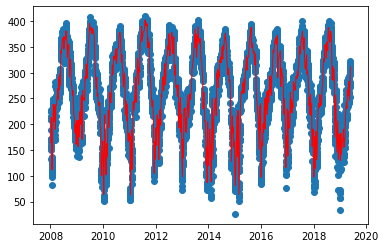

In [22]:
element = 'TMAX'
subset_df = us_complete_weekly[us_complete_weekly['element']==element]
plt.scatter(x=subset_df['date'],y=subset_df['value'])
median_avg = subset_df.groupby('date')[['date','value']].median().reset_index()
plt.plot(median_avg['date'],median_avg['value'],color='r', linestyle='-', linewidth=1)
plt.show()

### Method 3
Dask is a library that provides parallel and scalable way of working with pandas. However, I could not do groupby on month directly, like in pandas. I also could not subset my whole data to the location and elements I wanted without running out of memory. This attempt was unsuccessful.

In [23]:
country = "United States"
country_weather_df = dd.read_csv('output/*'+country+'.csv.gz',compression='gzip',blocksize=None,
                             parse_dates=['date'], dtype={'station': 'object',
 'element': 'object',
 'value': 'int64',
 'mflag': 'object',
 'qflag': 'object',
 'sflag': 'object',
 'obstime': 'float64',
 'country': 'object'})
country_weather_df

,station,date,element,value,mflag,qflag,sflag,obstime,country
npartitions=12,,,,,,,,,
,object,datetime64[ns],object,int64,object,object,object,float64,object
,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...


In [24]:
condition2 = (country_weather_df['station'].isin(us_stations)) & \
            (country_weather_df['element'].isin(['TMIN','TMAX','PRCP']))

In [25]:
country_weather_monthly = country_weather_df[condition2].groupby(['station','element',pd.Grouper(key='date',freq='M')])['value'].mean()

In [26]:
condition2.compute()

MemoryError: 

In [27]:
weather_monthly = country_weather_df.groupby(['station','element',country_weather_df['date'].dt.month])['value'].mean()
weather_monthly = weather_monthly[condition2].compute()

NotImplementedError: Series getitem in only supported for other series objects with matching partition structure

In [28]:
weather_monthly = country_weather_df.groupby(['station','element',pd.Grouper(key='date',freq='M')])['value'].mean()
weather_monthly = weather_monthly[condition2].compute()

NotImplementedError: Series getitem in only supported for other series objects with matching partition structure

### Conclusion

In dealing with a big problem, investigate what solutions are already available. Sometimes the available solution may not work for the use case.

Defining and understanding what needs to be done with the data goes a long way in resolving our issue. In this case, I was able to read in each file individually, even though it has 65 million rows, subset the data to what is needed, and build a dataframe of all the needed data.

If the above process is to be repeated again and again, the data can be rewritten in parquet format to enable efficient reads for subsequent steps.

DAILY GLOBAL HISTORICAL CLIMATOLOGY NETWORK (GHCN-DAILY) 
Version 3.26

Data has been downloaded from 
ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/


Menne, M.J., I. Durre, B. Korzeniewski, S. McNeal, K. Thomas, X. Yin, S. Anthony, R. Ray, 
R.S. Vose, B.E.Gleason, and T.G. Houston, 2012: Global Historical Climatology Network - 
Daily (GHCN-Daily), Version 3.26.
NOAA National Climatic Data Center. http://doi.org/10.7289/V5D21VHZ May 27 2019.